# P2I-7 - MODELISATION NUMERIQUE POUR L’INGENIEUR 

## SUJET N°5 - Capteur MEMS résonant pour la mesure de masse de ultra-haute précision 
 
Professeur référent : Sebastien BAGUET 

Auteurs : BERTRAND Thomas - CHAN Taihani – HAUSERMANN Tristan – DOUMIT Marc

## Contexte 

L'amélioration des techniques industrielles permet aujourd'hui le développement de composants
technologiques de plus en plus petits. Ils ouvrent la porte à de nombreux domaines d'application tels que la
navigation, les télécommunications, les jeux vidéo, etc.

Les capteurs MEMS/ NEMS (Micro/Nano Electro Mechanical Systems) font partie des systèmes qui ont
connu le plus d’avancées ces dernières années. Ces nano-systèmes, ayant des dimensions de l’ordre de
quelques dizaines de nanomètres, permettent de mesurer des perturbations extérieures (ajout de masse,
modification de propriétés chimiques, effort tiers...) très fines. Un MEMS représente donc une solution fiable
et précise pour concevoir un accéléromètre ou un capteur de pression par exemple.

**Dans ce projet, nous nous intéressons spécifiquement à la simulation d’un capteur MEMS de mesure
de masse d'ultra haute précision.**

Celui-ci fonctionne grâce à la résonance d'une nano-poutre soumise à une force électromagnétique induite
par deux sources de tension : une continue et une alternative.

**Nous étudions l'effet de l'ajout d'une masse sur le comportement du système résonnant et la
quantification de celle-ci en mesurant la variation de fréquence propre induite.**


PHOTO/schéma 

 La nano-poutre est soumise à une tension continue via une électrode 𝑉𝑑𝑐 qui fait fléchir la poutre, alors
qu'une tension alternative harmonique 𝑉𝑎𝑐 la sollicite sur sa fréquence fondamentale de flexion (au maximum
d'amplitude). L’ajout d’une petite masse change la masse totale du résonateur et induit donc un changement de
sa fréquence fondamentale, ce qui permet de déduire la valeur de la masse ajoutée.

À noter que : plus la taille du résonateur est petite, plus la fréquence fondamentale est grande (du MHz
au GHz) et plus la sensibilité du dispositif à une perturbation est grande. Une sensibilité élevée entraîne de
meilleures performances de mesure, telle qu'une plus grande gamme de mesures.

In [1]:
# import des librairies additionnelles
import numpy as np
import matplotlib.pyplot as plt

# Importation des fichiers
import newmark as nk
import newmark_masse_ajoutee as nk_ma
import newmark_saut as nk_s
import saut_final as sf
import saut_test as st
import trace_delta_m_f as dmf

%matplotlib widget
#%matplotlib notebook
#%matplotlib ipympl

Amplitude of the periodic solution: 0.1549353256641261
Amplitude of the periodic solution: 0.4891306501527157
Amplitude of the periodic solution: 0.71077291350848
Amplitude of the periodic solution: 0.7107729613098436


## Modélisation du problème 

Pour simplifier la modélisation et le traitement numérique du problème, on adopte un modèle de type masse-ressort à un degré de liberté, excité par les efforts électrostatiques générés par l’électrode.

<center>
<img src="./modele_simplifié_resonateur.JPG" alt width=300 heigth=350>

Figure 2 : Modèle simplifié masse-ressort avec masse ajoutée $\delta m$
</center>

L'équation du mouvement issue du Principe Fondamentale de la Dynamique sur $\vec{x}$ pour le modele simplifié est : 
$$ m \ddot{x} + c \dot{x} + k x = F_e(x,t)$$

$x$ étant le déplacement du bout de la poutre et $\dot{x}$, $\ddot{x}$ ses dérivées par rapport au temps t.

Avec :
- La force électrostatique non-linéaire est : $ F_e(x,t) = \frac{\varepsilon_0 A}{2} \cdot \frac{\left[ V_{dc} + V_{ac} \cos(\omega t) \right]^2}{(d - x)^2}$ 
- $m = \rho A h$ : masse de la nano-poutre de masse volumique $\rho$ homogne
- $c$ et $k$ : coefficient d'amortissement et de raideur
    
    Et : 
    - $\epsilon_0 = 8.5*10^{-12} F.m^{-1} $ : permitivité diélectrique absolue du vide
    - $A=l*h $ : surface de la masse en vis-à-vis de l’électrode
    - $d$ : distance masse-électrode
    - $\omega$ : pulsation liée à l'excitation alternative
    - $V_{dc}$ : tension continue dans l'éléctrode
    - $V_{ac}$ : tension alternative dans l'éléctrode


**Cependant** :
Il est nécessaire d’adimensionner les variables $x$ et $\omega$ car, les ordres de grandeur étant significativement différents entre eux, nous pourrions obtenir des résultats aberrants lors de la mise en place d’un schéma numérique.

On pose :
- $\tau = \omega_0t$ le temps adimensionné avec $\omega_0 = \sqrt{\frac{k}{m}}$ la pulsation propre du système
- $\Omega = \frac{\omega}{\omega_0}$ la pulsation adimensionnée
- $y = \frac{x}{d}$ le déplacement sur $\vec{x}$ adimensionné

En introduisant un développement limité à la force élétrostatique au coefficient $\frac{1}{(1-y)²}$, l'équation du mouvement du bout de la poutre devient :
$$\left(1 + \frac{\delta m}{m} \right)\ddot{y} + \xi \dot{y} + \left(1 - 2T V_{dc}^2 \right)y - \left(3T V_{dc}^2 \right)y^2 - \left(4T V_{dc}^2 \right)y^3 = T V_{dc}^2 + 2T V_{dc} V_{ac} \cos(\Omega \tau)$$

Avec : $T = \frac{\varepsilon_0 A}{2m \omega_0^2 d^3}$

Elle peut se mettre sous la forme:
$$M \ddot{y} + C \dot{y} + K y + f_{nl}(y) = p(\tau)$$

Et:
- $M = 1 + \frac{\delta m}{m}$
- $C = \xi = \frac{c}{mw_0} $
- $K = (1 - 2T V_{dc}^2) $
- $f_{nl}(y) = - (3T V_{dc}^2)y^2 - (4T V_{dc}^2)y^3$
- $p(\tau) = T V_{dc}^2 + 2T V_{dc} V_{ac} \cos(\Omega \tau)$


Cette équation est non-linéaire. Ainsi, nous ne sommes pas en mesure de trouver une solution analytique.
C’est pourquoi nous utiliserons des schémas d’intégration afin d’obtenir la solution numérique du mouvement.










## Modélisation du déplacement de la poutre avec l’algorithme de Newmark

Dans un premier temps, nous travaillons sans masse ajoutée sur la poutre. Nous mettons en place
l’algorithme de Newmark afin de tracer une courbe de réponse de la position de l’extrémité de la nano-poutre
en fonction du temps.

La courbe est obtenue pour une pulsation Ω donnée, avec deux conditions initiales sur la position et la
vitesse. Ainsi, nous observons le déplacement de la poutre lorsqu’elle est écartée de sa position d’origine et
mise en mouvement par une perturbation extérieure.



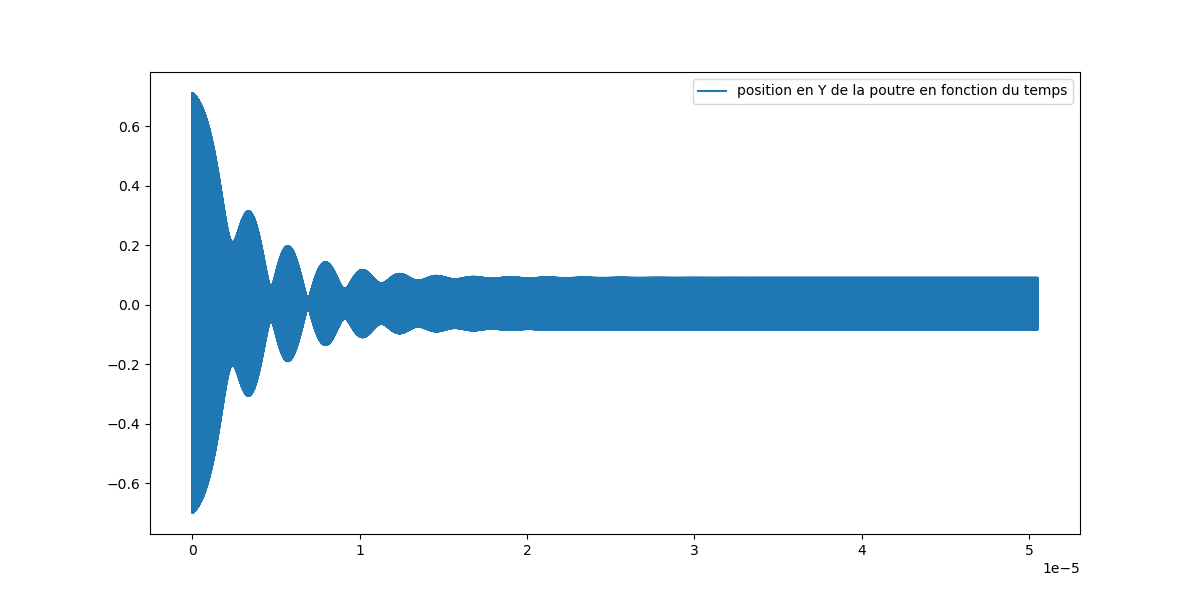

In [9]:
T, Vdc, Vac, omega0, M, C, K = nk.init_params()

OMEGA = 0.99
periode = 2 * np.pi / OMEGA  # Period of excitation and response
nb_pts_per = 50             # Number of points per period for time integration
dt = periode / nb_pts_per   # Time step size
nb_per = 5000               # Number of periods for time integration
t_tot = nb_per * periode    # Final time
t_init = 0                  # Initial time
NT = nb_per * nb_pts_per
tt, Yt, dYt = nk.Newmark(0.5, 0.5, 0, dt,NT,omega0,T,Vdc,Vac,OMEGA,M,C,K)

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(tt/omega0, Yt, label='position en Y de la poutre en fonction du temps')
ax.legend()
plt.show()

Nous pouvons distinguer deux phases dans la variation de la position dans le temps. Un premier régime
transitoire qui tend à se stabiliser sur un régime permanent harmonique.
Cette solution numérique semble satisfaisante car elle reflète fidèlement le comportement de la nano-poutre,
dont le déplacement va progressivement diminuer d’amplitude avant de retrouver son fonctionnement normal.

## Méthode 1 : Décalage en fréquence

### Tracé d’une courbe de réponse du résonateur sans masse ajoutée

Nous pouvons alors, en utilisant les dernières périodes du régime permanent établi, obtenir l’amplitude
maximale atteinte.

En faisant varier Ω, nous pouvons, avec les amplitudes, tracer la courbe de réponse entre deux bornes de
Ωmin et Ωmax données. Pour cela nous calculons les amplitudes maximales en augmentant Ω et également en le
diminuant dans un second temps. Cela nous permet d’avoir les deux réponses d’amplitude possibles dans la
phase de non-linéarité. Nous comparons avec les données fournies en superposant les deux courbes de réponse. En exploitant ce fichier nous pouvons tracer la superposition des deux courbes. 

Cependant, pour mesurer le décalage en fréquence, il est important d’avoir un nombre de points suffisants autour de l’amplitude maximale de la courbe de réponse. Pour ce faire, nous fixons un pas d’itération dΩ très petit autour de ce point, et uniquement à cet endroit. Le raffinage réalisé uniquement sur cette zone permet de nettement réduire le temps de calcul nécessaire pour les tracés.

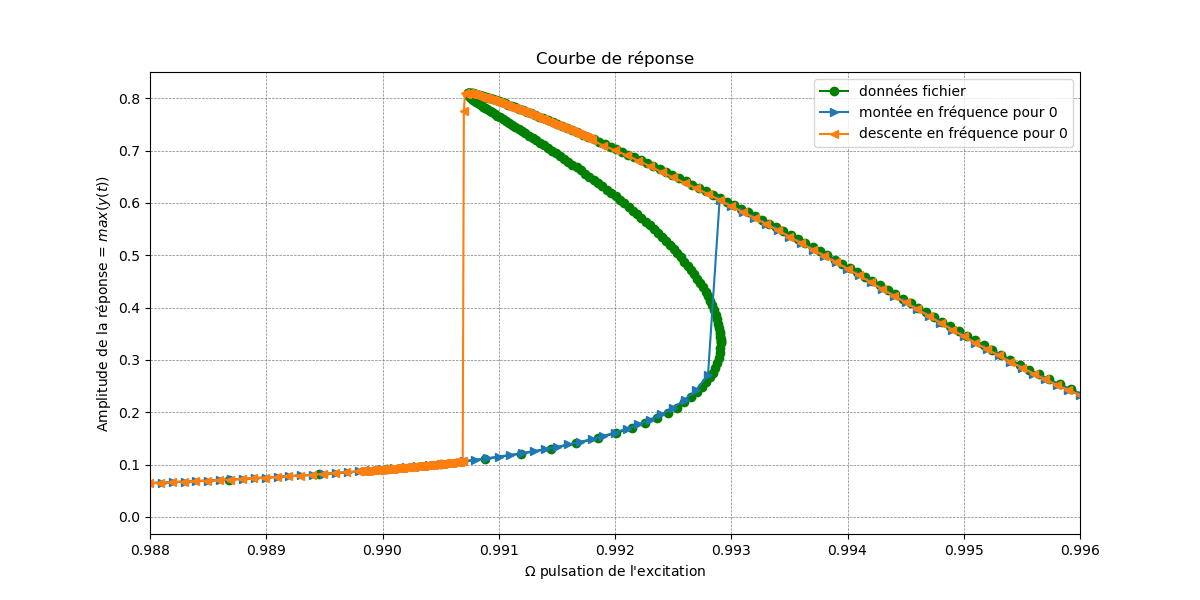

In [8]:
fig, ax = plt.subplots(figsize = (12,6))

dOMEGAinit = 0.0001
OMEGA_debut = 0.98
OMEGA_fin = 1.1
OMEGA_data, AMPL_data = nk.recuperer_courbe_data()

OME, AMPL = nk.compute_response_curve(T, Vdc, Vac, omega0, M, C, K, OMEGA_debut, OMEGA_fin, dOMEGAinit, nb_pts_per, nb_per, tolerance=0.00001)
OME2, AMPL2 = nk.compute_response_curve(T, Vdc, Vac, omega0, M, C, K, OMEGA_fin, OMEGA_debut, -dOMEGAinit, nb_pts_per, nb_per, tolerance=0.00001)

plot = nk.plot_response_curve(OME, AMPL, OME2, AMPL2, OMEGA_data, AMPL_data, ax, deltam=0, tracer_data=True)

###  Modification du modèle et ajout d’une masse $\delta m$

Maintenant que le modèle fonctionne sans masse ajoutée, nous pouvons simuler l’ajout d’une petite masse
sur la poutre en modifiant la valeur de la masse adimensionnée 𝑀. En utilisant le même algorithme que celui
des étapes précédentes, nous traçons la courbe de réponse du capteur pour une masse ajoutée allant de $10^{-12} kg$ à $10^{-15} kg$ et la comparons à celle sans masse ajoutée.

Avec ces courbes de réponse, nous observons que plus la masse ajoutée est grande, plus la courbe se déplace
vers les valeurs plus faibles de la pulsation.

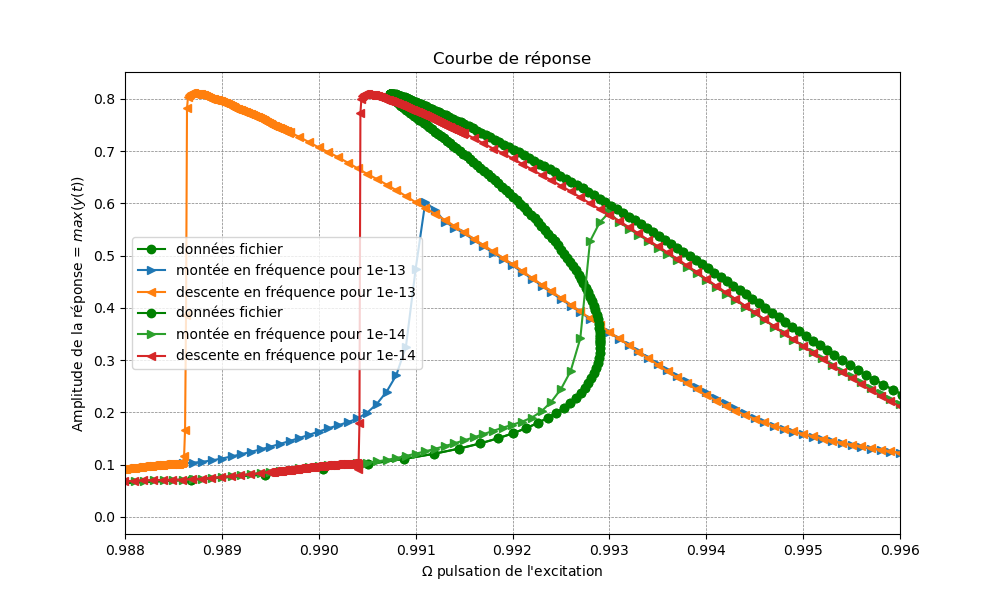

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))

dOMEGAinit = 0.0001
OMEGA_debut = 0.98
OMEGA_fin = 1.1

OMEGA_MAX, OME, AMPL, OME2, AMPL2 = nk_ma.courbe_reponse_delta_m(OMEGA_debut, OMEGA_fin, dOMEGAinit, deltam=1e-13, montee=True, data = True)

plot = nk.plot_response_curve(OME, AMPL, OME2, AMPL2, OMEGA_data, AMPL_data, ax, deltam=1e-13, tracer_data=True)

OMEGA_MAX, OME, AMPL, OME2, AMPL2 = nk_ma.courbe_reponse_delta_m(OMEGA_debut, OMEGA_fin, dOMEGAinit, deltam=1e-14, montee=True, data = True)

plot = nk.plot_response_curve(OME, AMPL, OME2, AMPL2, OMEGA_data, AMPL_data, ax, deltam=1e-14, tracer_data=True)

### Régression du décalage en fréquence en fonction de la masse ajoutée

Nous pouvons alors mesurer le décalage des deux courbes en mesurant la différence de pulsation d’un point
particulier. Nous avons choisi le sommet du pic de résonance afin d’avoir un point caractéristique pour chaque
courbe.

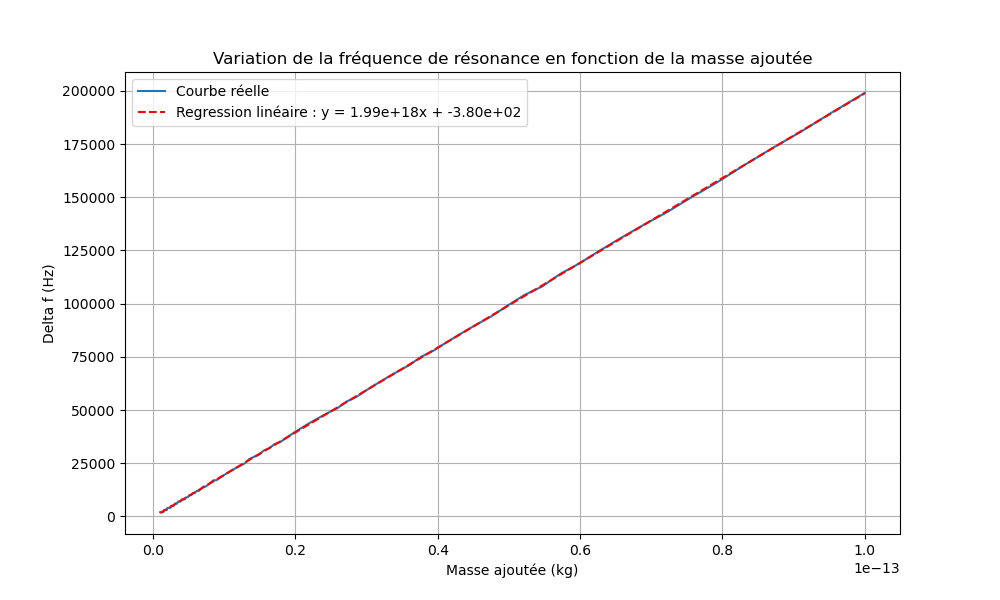

In [ ]:
# Paramètres
liste_delta_m = np.logspace(-15, -13, 100, base=10)
OMEGA_debut = 0.985
OMEGA_fin = 1
dOMEGA = 0.0003
f0 = 100e6

# Tracé
fig, ax = plt.subplots(figsize=(12,6))
dmf.tracer_delta_m_f(liste_delta_m, OMEGA_debut, OMEGA_fin, dOMEGA, f0)
plt.xlabel('Masse ajoutée (kg)')
plt.ylabel('Delta f (Hz)')
plt.title('Variation de la fréquence de résonance en fonction de la masse ajoutée')
plt.legend()
plt.grid()
plt.show()

À l'aide de la régression linéaire obtenue, nous pouvons en déduire la masse minimale détectable par le capteur de masse. 

Ainsi, nous pouvons mesurer des masses allant jusqu'à $m_{min} = 1,91.10^{-16} kg$

Afin de mieux visualiser les valeurs comprises entre $10^{-14}$ et $10^{-15}$, nous pouvons tracer la courbe en échelle logarithmique.

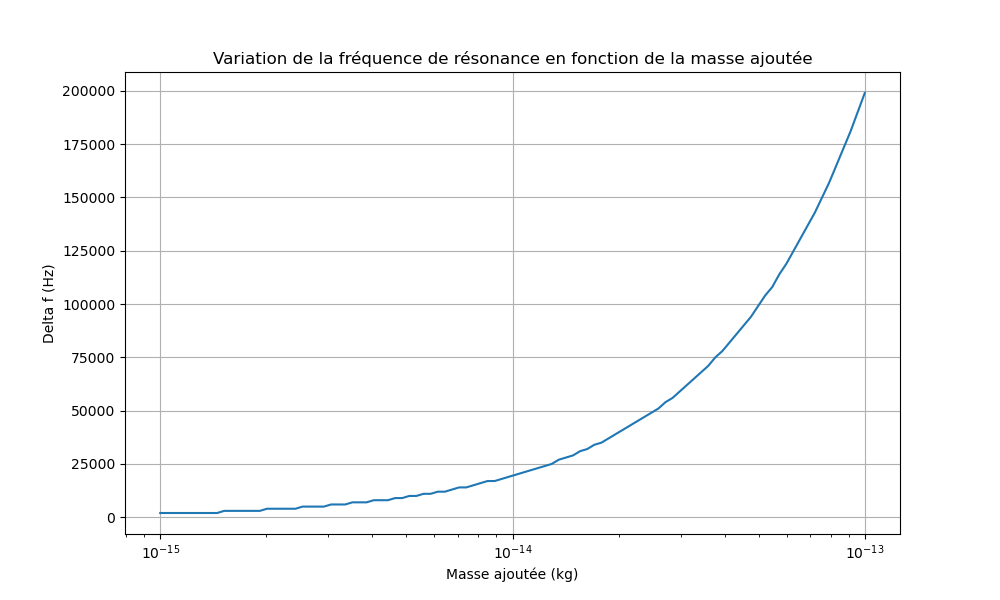

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

dmf.tracer_delta_m_f_log(liste_delta_m, OMEGA_debut,OMEGA_fin,dOMEGA, f0)
plt.xscale('log')
plt.xlabel('Masse ajoutée (kg)')
plt.ylabel('Delta f (Hz)')
plt.title('Variation de la fréquence de résonance en fonction de la masse ajoutée')
plt.grid()
plt.show()

Dans un premier temps, la méthode consiste à tracer la courbe de réponse en amplitude de déplacement de la poutre en fonction de la pulsation d'excitation, en l'absence de masse ajoutée (courbe référence). On superpose ensuite les courbes de réponse obtenues pour différentes masses ajoutées. En comparant les fréquences de résonance (positions des pics) entre la courbe de référence et celles modifiées, il est alors possible d’évaluer le décalage en fréquence due à l’ajout de masse. Cette variation permet d’estimer la masse ajoutée avec une certaine précision.

## Méthode 2 : Saut en amplitude
